Al-Imam Mohammad Ibn Saud Islamic University <br>
<font color = "Lightblue"> College of Computer & Information Sciences<br>
Computer Sciences Department</font>

 CS464 - Deep learning <br> Winter 22-23 - Second Semester | Project 
---

>Instructor : Dr. Haifa Alkasem


|       Prepared by :                  |              
| :------------------------------------------------ |
 Sarah Alaridi / 440023365
 Reem Alqahtani / 440019278
 Nourah Alsharhan / 440022381


## Download dataset 


In [ ]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail")

Skipping, found downloaded files in "./newspaper-text-summarization-cnn-dailymail" (use force=True to force download)


## Download and Import all necessary libraries

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import string
import numpy as np
import pandas as pd

## Read the dataset 

In [ ]:
''' loading data in chunks and concat the chunks back together for faster data loading '''

def load_csv_in_chunks(file_path, chunksize=1000, sample_size=20000):
    chunks = pd.read_csv(file_path, chunksize=chunksize)
    data = pd.concat(chunks).sample(n=sample_size, random_state=50)[['article']]
    return data

train= load_csv_in_chunks("/content/newspaper-text-summarization-cnn-dailymail/cnn_dailymail/train.csv")

In [ ]:
train.head()

,article
255916,Utah officials have asked the U.S. Supreme Cou...
22935,(CNN) -- U.S. Energy Secretary Ernest Moniz's ...
240409,Gary Lineker has backed under-fire forward Mar...
76669,"By . Suzannah Hills . PUBLISHED: . 08:33 EST, ..."
147100,An adult film star who tested positive for HIV...


In [ ]:
''' clean the data by remove punctuation and lower casing the words'''

import re

def clean_articles(df, cols="article"):
    df[cols] = df[cols].replace(string.punctuation, " ") # remove punctuation
    df[cols] = df[cols].apply(lambda x: str.lower(x)) # convert to lowercase
    return df

train = clean_articles(train)

In [ ]:
''' loading the stopwords package from nltk '''

from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# stop_words

In [ ]:
''' remove stopwords from the dataset'''

def remove_stop_words(df, cols="article"):
    df[cols] = df[cols].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    return df

train = remove_stop_words(train)

In [ ]:
''' tokenize the data set with Keras Tokenizer and compute the total words'''

tokenizer = Tokenizer()



tokenizer.fit_on_texts(train['article'])
total_words = len(tokenizer.word_index) + 1


In [ ]:
tokenizer.word_index

{'said': 1,
 "'": 2,
 'one': 3,
 'year': 4,
 'would': 5,
 'also': 6,
 'people': 7,
 'two': 8,
 'new': 9,
 'time': 10,
 'last': 11,
 'told': 12,
 'police': 13,
 'first': 14,
 'years': 15,
 'mr': 16,
 'could': 17,
 'old': 18,
 '’': 19,
 'like': 20,
 'home': 21,
 'back': 22,
 'left': 23,
 'three': 24,
 '000': 25,
 'day': 26,
 'made': 27,
 'world': 28,
 'get': 29,
 'family': 30,
 'found': 31,
 'right': 32,
 'may': 33,
 'it': 34,
 'around': 35,
 'many': 36,
 'cnn': 37,
 'u': 38,
 'says': 39,
 'even': 40,
 'life': 41,
 'court': 42,
 'make': 43,
 'according': 44,
 's': 45,
 "'i": 46,
 'since': 47,
 'man': 48,
 'way': 49,
 'take': 50,
 'going': 51,
 'still': 52,
 'well': 53,
 '1': 54,
 'week': 55,
 'work': 56,
 'children': 57,
 'say': 58,
 'government': 59,
 'video': 60,
 'house': 61,
 'four': 62,
 'go': 63,
 'see': 64,
 'former': 65,
 'us': 66,
 'another': 67,
 'think': 68,
 'est': 69,
 'know': 70,
 'president': 71,
 'city': 72,
 'state': 73,
 'team': 74,
 'much': 75,
 'including': 76,
 '–': 

In [ ]:
total_words

181565

In [ ]:
''' transform the data to be sequences ''' # 


def convert_to_n_grame(df, cols="article"):
    inputs_seq = [] # list of sequences
    for article in df[cols]: # loop over each sentences
        tokens_array = tokenizer.texts_to_sequences([article])[0] # list of tokens
    for i in range(1, len(tokens_array)):
        n_gram_seqs = tokens_array[:i+1]
        inputs_seq.append(n_gram_seqs)
    return inputs_seq


In [ ]:
train = convert_to_n_grame(train)

In [ ]:
''' pad the text to make all the sentences shape of the same size '''

def padd_sequences(inputs, input_seq):
    max_sequence_len = max([len(x) for x in input_seq]) # get the max length
    input_sequences = np.array(pad_sequences(inputs, maxlen=max_sequence_len, padding='pre')) # Padding
    
    predictors, label = input_sequences[:,:-1], input_sequences[:,-1] # Silicing The Array
    label = tf.keras.utils.to_categorical(label, num_classes=total_words) # transform to one hot encoding vectors
    return predictors, label, max_sequence_len

train_data, train_label, max_sequence_length = padd_sequences(train, train)

In [ ]:
''' model building with embeding layer and 1 Bidirectional LSTM layer with 128 unit.
 a dropout layer with 10% of the weights turned off.
output layer of labels length and softmax activation to get the probabiaties

the loss function is categorical cross entropy for computing the loss and perform back propagation.
the optimizer is adam.'''

max_sequence_length = max_sequence_length -1

def model_building():

    from keras.models import Sequential
    from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
    model = Sequential() # the Model
    model.add(Embedding(total_words, 32, input_length=max_sequence_length)) # embedding Layer
    model.add(Bidirectional(LSTM(128))) # Biderictional LSTM
    model.add(Dropout(0.3)) # Dropout Layer with 30% drop off
    model.add(Dense(total_words, activation='softmax')) # softmax find the probabilaties for the words

    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

model = model_building()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 937, 32)           5810080   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              164864    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 181565)            46662205  
                                                                 
Total params: 52,637,149
Trainable params: 52,637,149
Non-trainable params: 0
_________________________________________________________________


In [ ]:
''' train the model with training data and validate the model with validation data with 200 epochs'''

history=model.fit(train_data, train_label,
                  epochs=200)

Epoch 1/200
30/30 [==============================] - 9s 159ms/step - loss: 11.8267
Epoch 2/200
30/30 [==============================] - 4s 119ms/step - loss: 8.1067
Epoch 3/200
30/30 [==============================] - 3s 96ms/step - loss: 7.0358
Epoch 4/200
30/30 [==============================] - 3s 114ms/step - loss: 6.6885
Epoch 5/200
30/30 [==============================] - 3s 102ms/step - loss: 6.5411
Epoch 6/200
30/30 [==============================] - 3s 98ms/step - loss: 6.4724
Epoch 7/200
30/30 [==============================] - 3s 98ms/step - loss: 6.4504
Epoch 8/200
30/30 [==============================] - 3s 116ms/step - loss: 6.4157
Epoch 9/200
30/30 [==============================] - 3s 98ms/step - loss: 6.4158
Epoch 10/200
30/30 [==============================] - 3s 95ms/step - loss: 6.3977
Epoch 11/200
30/30 [==============================] - 3s 94ms/step - loss: 6.3709
Epoch 12/200
30/30 [==============================] - 3s 112ms/step - loss: 6.3502
Epoch 13/200
30/30

In [ ]:
''' a function to generate text with speciefied length of words ''' 

def generate_text(opening_text, next_words, estimator, max_sequence_len):
    for _ in range(next_words):
        tokens = tokenizer.texts_to_sequences([opening_text])[0] # To take the number corresponding to the text
        tokens = pad_sequences([tokens], maxlen=max_sequence_len-1, padding='pre')
        predicted_probabilaties = model.predict(tokens, verbose=0)
        predicted = np.argmax(predicted_probabilaties)
        
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        opening_text += " "+output_word
    return opening_text.title()

In [ ]:
generate_text("London", 20, model, max_sequence_length+1)

'London Attention Everyone Else Tim Shudders ‘I See Attraction Roses Clematis None Whatsoever Get Diseases Need Lots Attention Everyone Else Growing'

In [ ]:
generate_text("the girl", 15, model, max_sequence_length+1)

'The Girl View Tim Sheila Wilmot’S Bedroom Window Is Frankly Rather Astonishing Palm Trees High Houses Sway'

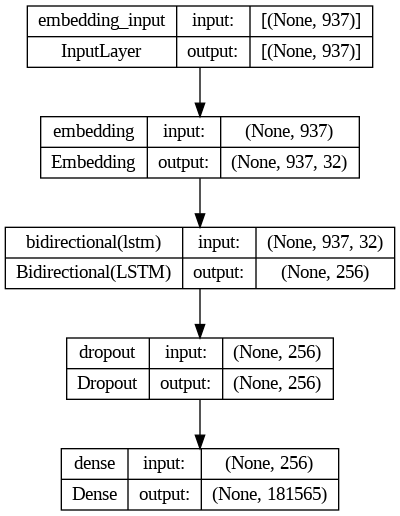

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', rankdir="TB", show_layer_names=True)